In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from matplotlib.colors import Normalize

In [2]:
ratings = pd.read_csv('../data/ratings.csv')
movies = pd.read_csv('../data/movies.csv')


data_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

Number of users:  610
Sparsity:  0.9830003169443864


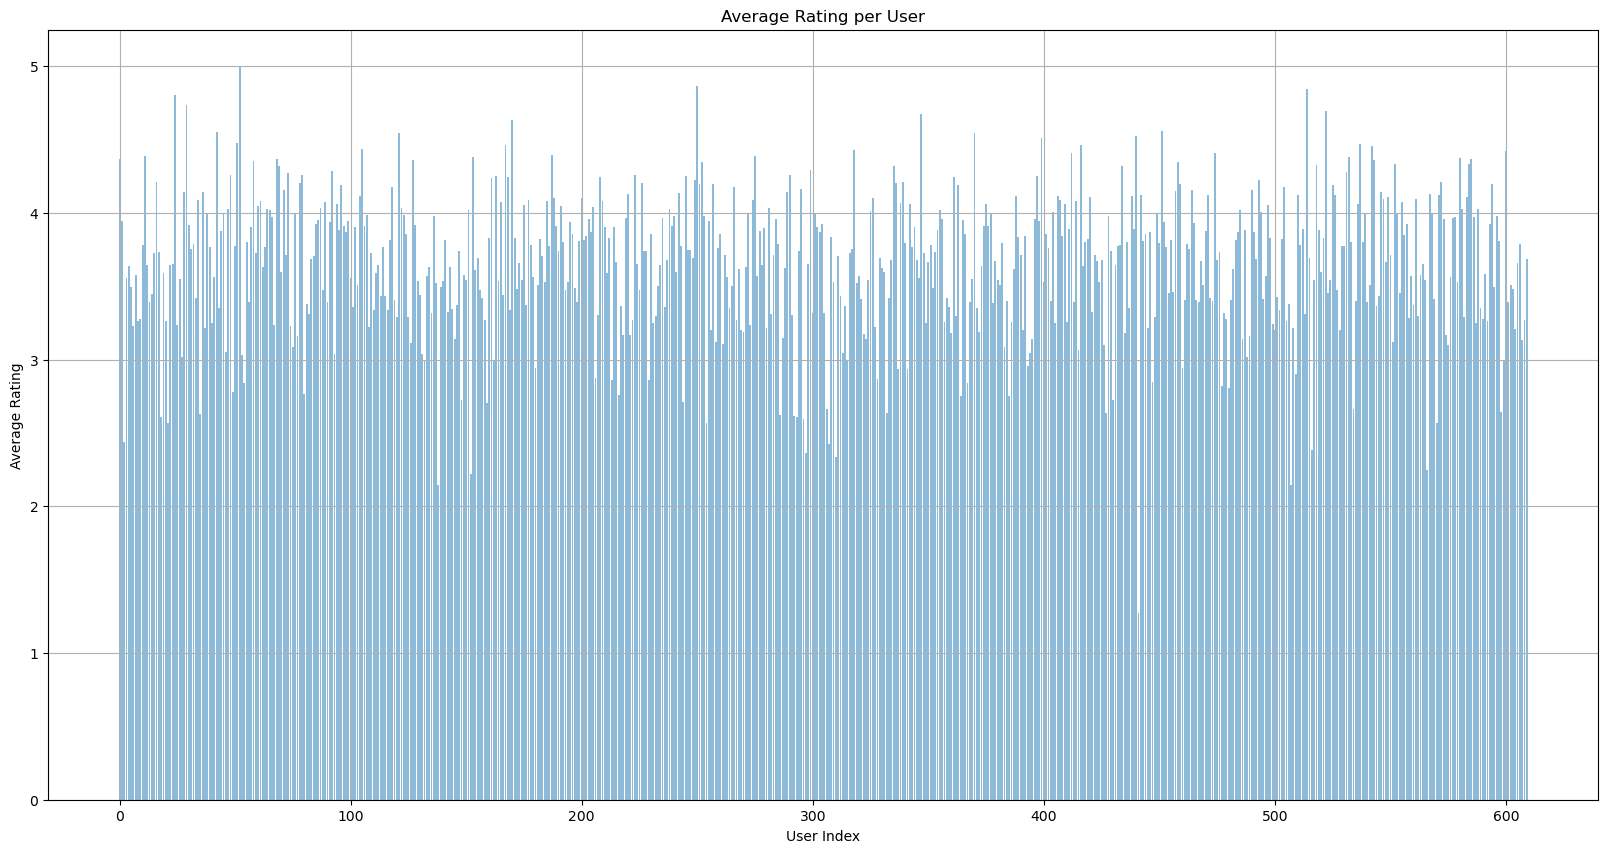

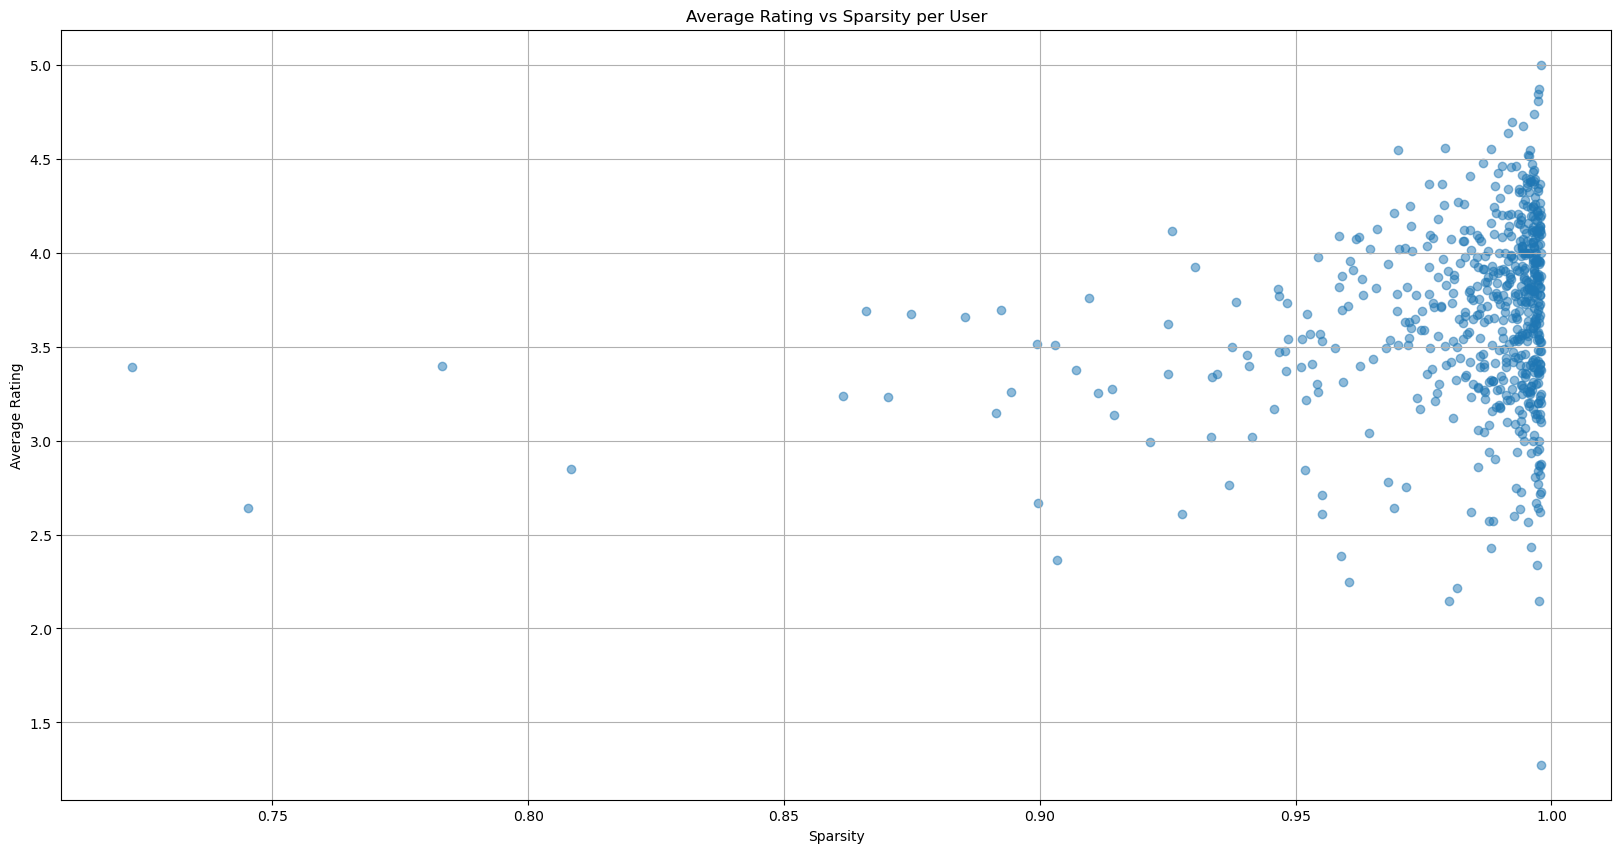

In [3]:
# In this cell we will analyze the data matrix and plot some statistics

print("Number of users: ", data_matrix.shape[0])

total_entries = data_matrix.shape[0] * data_matrix.shape[1]
nan_entries = np.isnan(data_matrix).sum().sum()
print("Sparsity: ", nan_entries / total_entries)


average_per_user = data_matrix.mean(axis=1)
indices = np.arange(data_matrix.shape[0])
plt.figure(figsize=(20, 10))
plt.bar(indices, average_per_user, alpha=0.5)
plt.title('Average Rating per User')
plt.xlabel('User Index')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()


sparcity_per_user = np.isnan(data_matrix).sum(axis=1) / data_matrix.shape[1]
plt.figure(figsize=(20, 10))
plt.scatter(sparcity_per_user, average_per_user, alpha=0.5)
plt.title('Average Rating vs Sparsity per User')
plt.xlabel('Sparsity')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()



In [4]:
# In this cell we will implement the NMF algorithm
# X: data matrix
# n_components: number of components to use
# test_indices: indices of the test set
# max_iter: maximum number of iterations
# tol: tolerance for the stopping criterion

def nmf(X, n_components, test_indices, max_iter=100, tol=1e-6):

    for position in test_indices:
        assert np.isnan(X[position[0], position[1]])


    known_mask = ~np.isnan(X)
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    error = np.inf
    X_non_nan = np.nan_to_num(X, nan=0)
    for i in range(max_iter):
        X_hat = W @ H
        H = H * (W.T @ (known_mask * X_non_nan) / (W.T @ (known_mask * X_hat) + 1e-9))
        X_hat = W @ H
        W = W * ((known_mask * X_non_nan) @ H.T / ((known_mask * X_hat) @ H.T + 1e-9))

        frobenius_norm = np.linalg.norm(known_mask * (X_non_nan - X_hat), 'fro')
        error = frobenius_norm
        if frobenius_norm < tol:
            break

    return W, H, error

In [5]:
def cross_validation(V, nmf, n_components, k=5):
    np.random.seed(42)
    non_nan_indices = np.argwhere(~np.isnan(V))

    np.random.shuffle(non_nan_indices)
    fold_size = len(non_nan_indices) // k
    fold_errors = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        test_indices = non_nan_indices[start:end]

        V_train = np.copy(V)
        for position in test_indices:
            V_train[position[0], position[1]] = np.nan

        W, H, _ = nmf(V_train, n_components, test_indices)

        V_hat = W @ H

        error_curent_fold = 0
        for (row, col) in test_indices:
            error_curent_fold += (V[row, col] - V_hat[row, col]) ** 2

        fold_errors.append(error_curent_fold / len(test_indices))

    return np.mean(fold_errors)

In [ ]:
list_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
errors = []
computed_W = []
computed_H = []

np.random.seed(42)
for n_components in list_components:
    error = cross_validation(data_matrix.values, nmf, n_components, 5)
    print(f"Error for {n_components} components: {error}")
    errors.append(error)


Error for 10 components: 1.5600904765569692
Error for 20 components: 1.5934965499239628
Error for 30 components: 1.5774639602607863
Error for 40 components: 1.5483676466994165
Error for 50 components: 1.5174175045434
Error for 60 components: 1.4914679284770513
Error for 70 components: 1.4676714898069068
Error for 80 components: 1.4509254572352985
Error for 90 components: 1.435614705269976


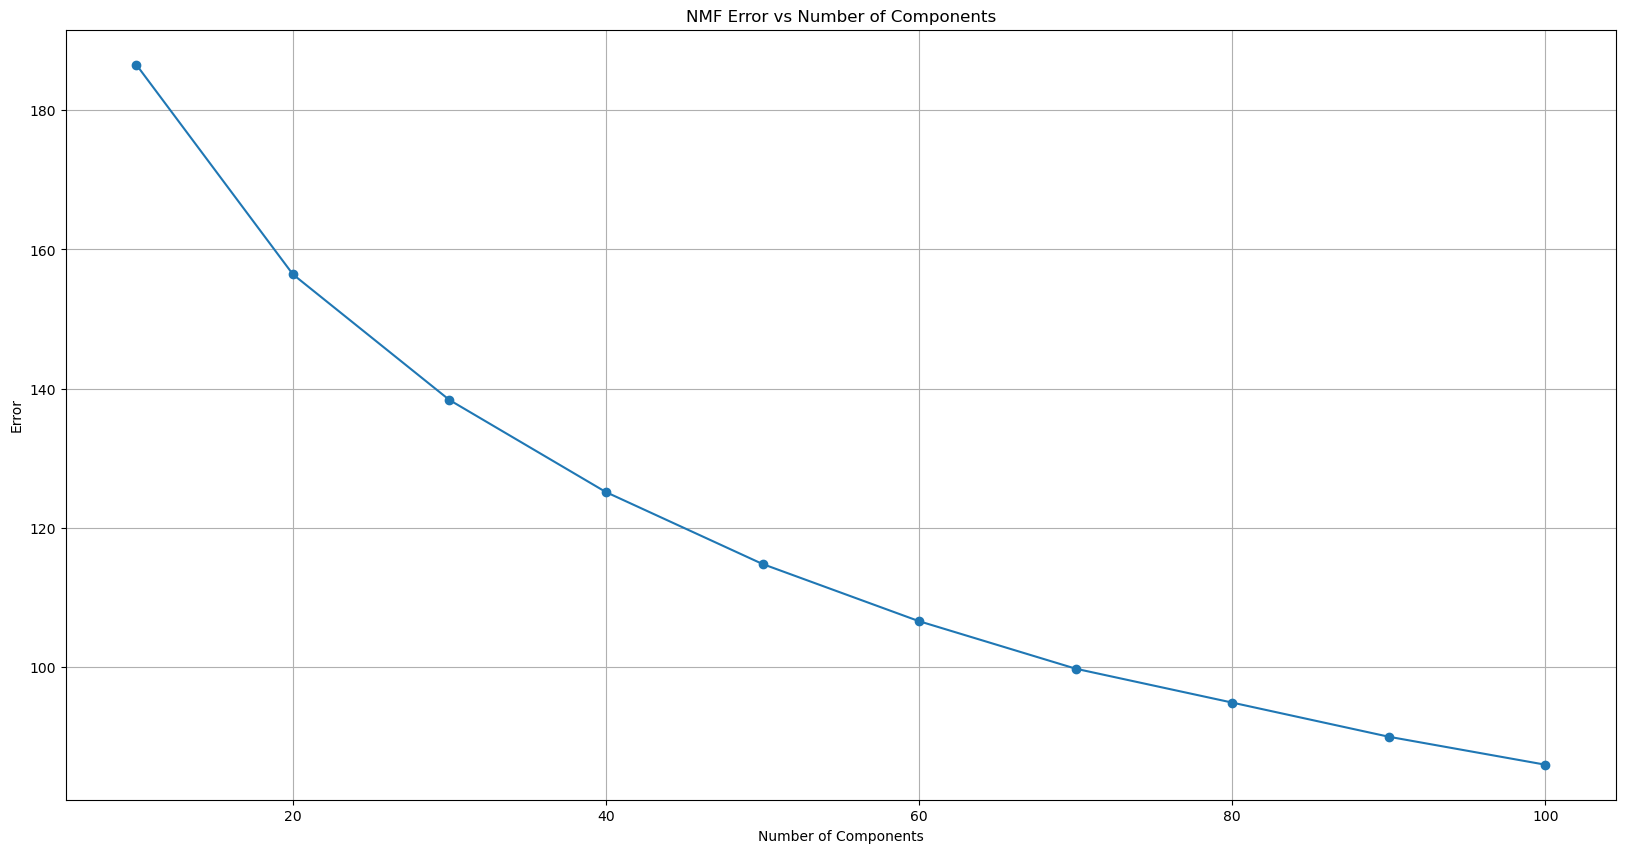

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(list_components, errors, marker='o')
plt.title('NMF Error vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Error')
plt.grid(True)
plt.show()